In [368]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.io_utils as io_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
import matching.misc.cpg_const as cpg_const
from matching.glema.common.utils.plot_utils import ColorScheme

In [369]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "dpdf"
#args.dataset = "CPG_augm_large"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

result_dir = os.path.join( args.result_dir, model_name )
subgraph_matching_file = io_utils.get_abs_file_path( os.path.join( result_dir, "result.csv" ) )
pattern_matching_file = io_utils.get_abs_file_path( os.path.join( result_dir, "result_pattern_matching.csv" ) )
pattern_matching_sources_file = io_utils.get_abs_file_path(
    os.path.join( result_dir, "result_pattern_matching_sources.csv" ) )

In [370]:
DESIGN_PATTERN_MAPPING = {
    #cpg_const.DesignPatternType.ABSTRACT_FACTORY.value: "Abstract Factory",
    cpg_const.DesignPatternType.ADAPTER.value: "Adapter",
    cpg_const.DesignPatternType.BUILDER.value: "Builder",
    #cpg_const.DesignPatternType.FACADE.value: "Facade",
    cpg_const.DesignPatternType.FACTORY_METHOD.value: "Factory Method",
    cpg_const.DesignPatternType.OBSERVER.value: "Observer",
    cpg_const.DesignPatternType.SINGLETON.value: "Singleton",
    cpg_const.DesignPatternType.DECORATOR.value: "Decorator",
    cpg_const.DesignPatternType.MEMENTO.value: "Memento",
    #cpg_const.DesignPatternType.PROTOTYPE.value: "Prototype",
    #cpg_const.DesignPatternType.PROXY.value: "Proxy",
    #cpg_const.DesignPatternType.VISITOR.value: "Visitor",
    cpg_const.NO_DESIGN_PATTERN: "None",
}

DATASET_KEY = "dataset"
RECORD_KEY = "record"
TRUE_KEY = "true_type"
PRED_KEY = "pred_type"
PRED_SCORE_KEY = "pred_score"

CONFIDENCE_KEY = "Confident"
TIME_KEY = "Execution Time"
ROC_KEY = "ROC AUC"
PR_KEY = "PR AUC"
PREC_KEY = "Precision"
REC_KEY = "Recall"
F1_KEY = "F1-Score"
ACC_KEY = "Accuracy"
PATTERN_KEY = "Pattern"

METRIC_COMPUTE_MAPPING = {
    ROC_KEY: "roc",
    PR_KEY: "avp",
    PREC_KEY: "pre",
    REC_KEY: "rec",
    F1_KEY: "f1s",
    ACC_KEY: "acc"
}

KEY_MAPPING = {
    DATASET_KEY: "Project",
    RECORD_KEY: "Record",
    TRUE_KEY: "True Pattern",
    PRED_KEY: "Predicted Pattern",
    PRED_SCORE_KEY: "Prediction Score",
    CONFIDENCE_KEY: "Confidence",
    TIME_KEY: "Runtime (s)",
    ROC_KEY: "ROC AUC",
    PR_KEY: "PR AUC",
    PREC_KEY: "Precision",
    REC_KEY: "Recall",
    F1_KEY: "F1-Score",
    ACC_KEY: "Accuracy",
}

PROJECT_QUICK_UML = "QuickUML"
PROJECT_JUNIT = "JUnit"
PROJECT_J_HOT_DRAW = "JHotDraw"
PROJECT_MAPPER_XML = "MapperXML"
PROJECT_NUTCH = "Apache Nutch"
PROJECT_PMD = "PMD"

PROJECT_MAPPING = {
    "p_mart-1_-_quickuml_2001": PROJECT_QUICK_UML,
    "p_mart-5_-_junit_v37": PROJECT_JUNIT,
    "p_mart-6_-_jhotdraw_v51": PROJECT_J_HOT_DRAW,
    "p_mart-8_-_mapperxml_v197": PROJECT_MAPPER_XML,
    "p_mart-10_-_nutch_v04": PROJECT_NUTCH,
    "p_mart-11_-_pmd_v18": PROJECT_PMD,
}

NAN_MAPPING = "-"

In [371]:
subgraph_matching_df = pd.read_csv( subgraph_matching_file )
pattern_matching_df = pd.read_csv( pattern_matching_file )
source_pred_df = pd.read_csv( pattern_matching_sources_file, na_filter=False )

In [372]:
source_pred_df

,gidx,dataset,record,true_type,pred_type,pred_score
0,1022,p_mart-10_-_nutch_v04,net.nutch.db.DistributedWebDBWriter.LinkInstru...,N/A,MEMENTO,0.847555
1,1084,p_mart-10_-_nutch_v04,net.nutch.db.WebDBWriter.DeduplicatingPageSequ...,N/A,MEMENTO,0.847555
2,501,p_mart-6_-_jhotdraw_v51,CH.ifa.draw.framework.Painter,N/A,FACTORY_METHOD,0.816810
3,1133,p_mart-10_-_nutch_v04,net.nutch.net.protocols.http.ContentLengthPars...,N/A,FACTORY_METHOD,0.403143
4,760,p_mart-8_-_mapperxml_v197,com.taursys.swing.MTable,N/A,MEMENTO,0.702969
...,...,...,...,...,...,...
77,1052,p_mart-10_-_nutch_v04,net.nutch.io.MapFile.Writer,MEMENTO,MEMENTO,0.308176
78,1195,p_mart-10_-_nutch_v04,net.nutch.io.SetFile,MEMENTO,DECORATOR,0.402256
79,112,p_mart-5_-_junit_v37,junit.extensions.TestDecorator,DECORATOR,DECORATOR,0.562316
80,17,p_mart-5_-_junit_v37,junit.extensions.TestSetup,DECORATOR,BUILDER,0.878940


In [373]:
# remove rows with a true_type not in the MAPPING
source_pred_df = source_pred_df[ source_pred_df[ TRUE_KEY ].isin( DESIGN_PATTERN_MAPPING.keys() ) ]
# rows where pred_type is not in the MAPPING keys, set it to NONE
source_pred_df.loc[
    ~source_pred_df[ PRED_KEY ].isin( DESIGN_PATTERN_MAPPING.keys() ), PRED_KEY ] = cpg_const.NO_DESIGN_PATTERN
source_pred_df[ DATASET_KEY ] = source_pred_df[ DATASET_KEY ].map( PROJECT_MAPPING )
source_pred_df

,gidx,dataset,record,true_type,pred_type,pred_score
0,1022,Apache Nutch,net.nutch.db.DistributedWebDBWriter.LinkInstru...,N/A,MEMENTO,0.847555
1,1084,Apache Nutch,net.nutch.db.WebDBWriter.DeduplicatingPageSequ...,N/A,MEMENTO,0.847555
2,501,JHotDraw,CH.ifa.draw.framework.Painter,N/A,FACTORY_METHOD,0.816810
3,1133,Apache Nutch,net.nutch.net.protocols.http.ContentLengthPars...,N/A,FACTORY_METHOD,0.403143
4,760,MapperXML,com.taursys.swing.MTable,N/A,MEMENTO,0.702969
...,...,...,...,...,...,...
77,1052,Apache Nutch,net.nutch.io.MapFile.Writer,MEMENTO,MEMENTO,0.308176
78,1195,Apache Nutch,net.nutch.io.SetFile,MEMENTO,DECORATOR,0.402256
79,112,JUnit,junit.extensions.TestDecorator,DECORATOR,DECORATOR,0.562316
80,17,JUnit,junit.extensions.TestSetup,DECORATOR,BUILDER,0.878940


## Confusion Matrix

{'DECORATOR', 'SINGLETON', 'MEMENTO', 'OBSERVER', 'FACTORY_METHOD', 'BUILDER', 'ADAPTER'}


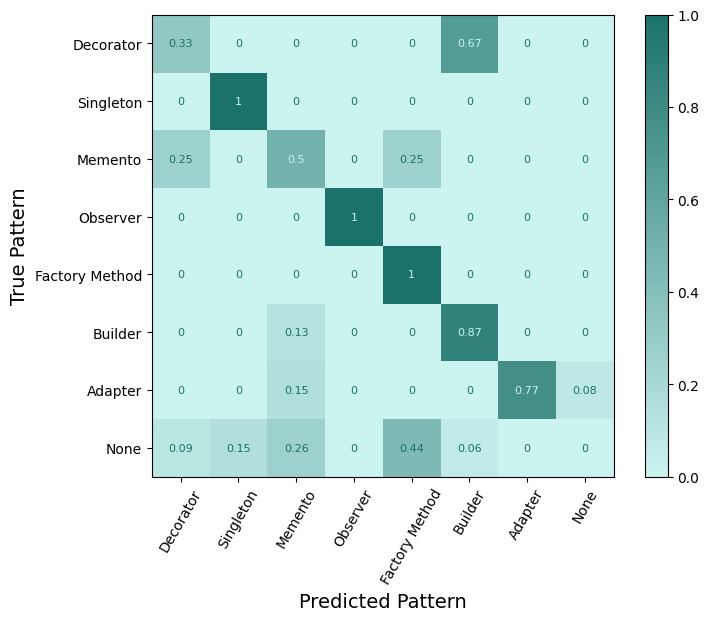

In [374]:
def compute_pred_cm( true_labels: list[ str ], pred_labels: list[ str ], file_name,
                     labels=None, include_na=True ):
    if labels is None:
        labels = [ dp.value for dp in cpg_const.DesignPatternType ]
    if include_na:
        labels = [ *labels, cpg_const.NO_DESIGN_PATTERN ]

    cm = confusion_matrix( true_labels, pred_labels, labels=labels, normalize="true" )
    cm = np.round( cm, 2 )

    display_labels = [ DESIGN_PATTERN_MAPPING[ label ] for label in labels ]
    fig, ax = plt.subplots( figsize=(8, 6) )
    disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=display_labels )

    cmap = LinearSegmentedColormap.from_list( "custom_cmap", [
        ColorScheme.SECONDARY_LIGHT,
        ColorScheme.SECONDARY_DARK ] )
    disp.plot( cmap=cmap, ax=ax, colorbar=True )

    for text in disp.text_.ravel():
        text.set_fontsize( 8 )
    plt.xlabel( KEY_MAPPING[ PRED_KEY ], fontsize=14 )
    plt.ylabel( KEY_MAPPING[ TRUE_KEY ], fontsize=14 )
    plt.xticks( fontsize=10, rotation=60 )
    plt.yticks( fontsize=10 )

    plt.savefig( f"plots/{file_name}", bbox_inches='tight', pad_inches=0.1 )


pattern_types = set( DESIGN_PATTERN_MAPPING.keys() )
pattern_types.remove( cpg_const.NO_DESIGN_PATTERN )
print( pattern_types )
true_labels = source_pred_df[ TRUE_KEY ].to_list()
pred_labels = source_pred_df[ PRED_KEY ].to_list()
compute_pred_cm( true_labels, pred_labels, "matching_cm", labels=pattern_types, include_na=True )

## Metric Value Progress 

In [375]:
subgraph_matching_df

,Confident,Execution Time,ROC AUC,PR AUC,Precision,Recall,F1-Score,Accuracy
0,0.50,0.000496,0.879406,0.861618,0.951431,0.800030,0.869187,0.879042
1,0.60,0.000496,0.865559,0.849810,0.955023,0.767603,0.851117,0.865109
2,0.70,0.000496,0.847597,0.833972,0.958597,0.726879,0.826810,0.847043
3,0.80,0.000496,0.823421,0.812328,0.963022,0.672919,0.792249,0.822730
4,0.90,0.000496,0.780099,0.772464,0.968991,0.578894,0.724787,0.779175
5,0.91,0.000496,0.773359,0.766202,0.969870,0.564413,0.713568,0.772399
6,0.92,0.000496,0.765554,0.758894,0.970729,0.547779,0.700352,0.764554
7,0.93,0.000496,0.755421,0.749400,0.971899,0.526197,0.682747,0.754368
8,0.94,0.000496,0.744143,0.738846,0.973367,0.502153,0.662518,0.743032
9,0.95,0.000496,0.728824,0.724322,0.974765,0.469926,0.634139,0.727635


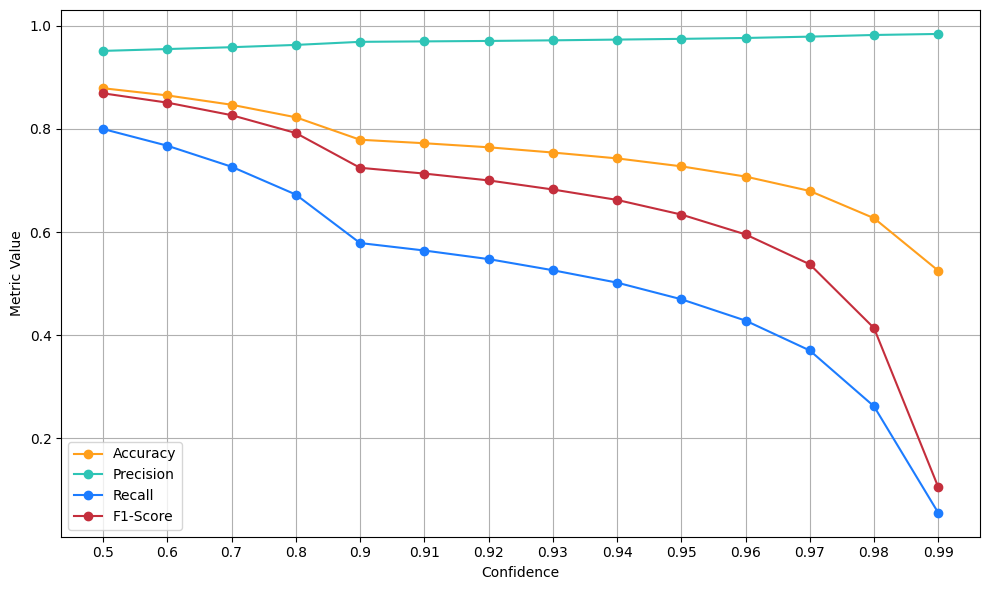

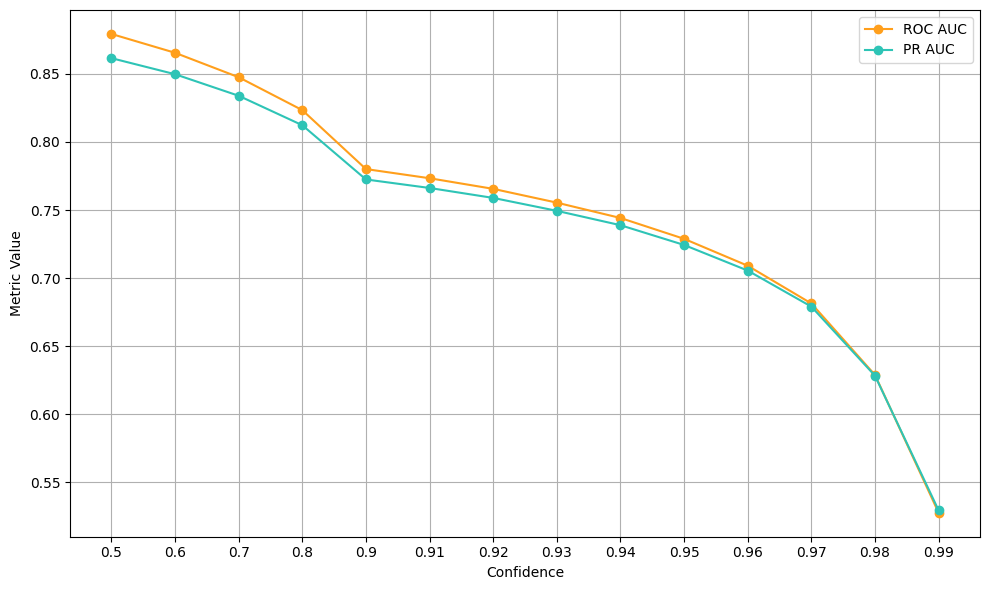

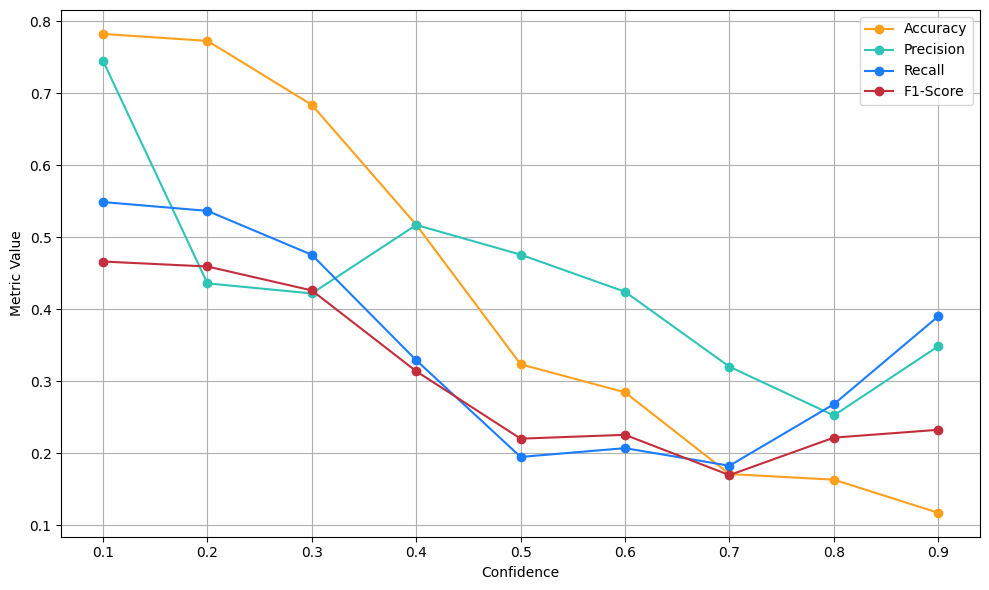

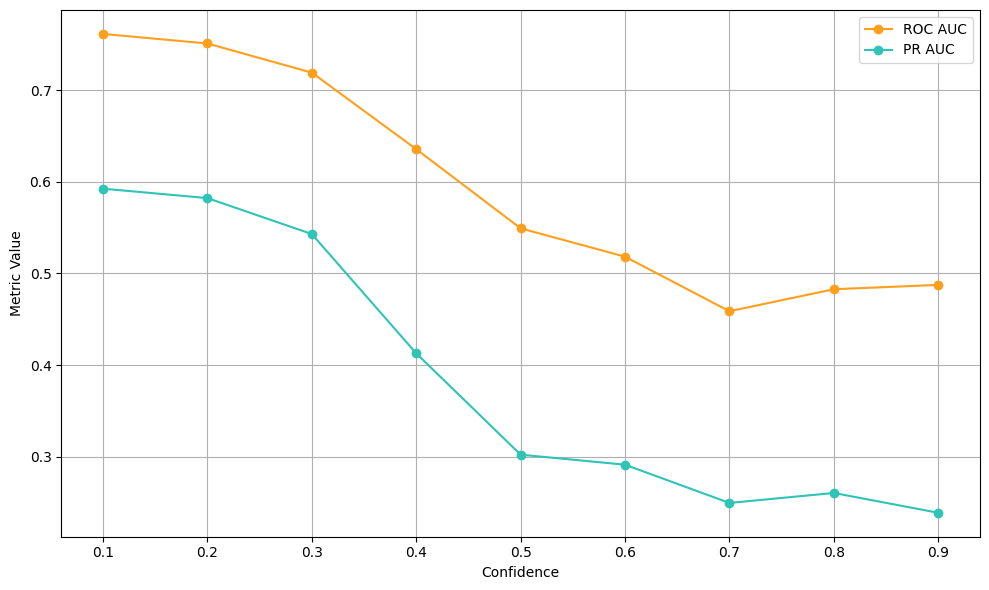

In [376]:
def plot_metrics( df, name, x_col,
                  metric_cols=None,
                  color_scheme=None,
                  force_even_x_spacing=False ):
    if metric_cols is None:
        # Use all columns except the x-axis column if metric_cols not provided
        metric_cols = [ col for col in df.columns if col != x_col ]

    plt.figure( figsize=(10, 6) )

    x_positions = df[ x_col ]
    if force_even_x_spacing:
        x_positions = range( len( df ) )

    # Plot each metric column
    for i, col in enumerate( metric_cols ):
        # Use a color from the color_scheme if provided, cycling if necessary
        color = color_scheme[ i % len( color_scheme ) ] if color_scheme else None
        plt.plot( x_positions, df[ col ], marker="o", label=KEY_MAPPING[ col ], color=color )

    plt.xlabel( KEY_MAPPING[ x_col ] )
    if force_even_x_spacing:
        plt.xticks( x_positions, df[ x_col ] )
    plt.ylabel( "Metric Value" )
    plt.legend()
    plt.grid( True )
    plt.tight_layout()
    plt.savefig( f"plots/metric_progress_{name}", bbox_inches='tight', pad_inches=0.1 )


metric_cols_1 = [ ACC_KEY, PREC_KEY, REC_KEY, F1_KEY ]
metric_cols_2 = [ ROC_KEY, PR_KEY ]

plot_metrics( subgraph_matching_df,
              "subgraph_matching_general",
              CONFIDENCE_KEY,
              color_scheme=ColorScheme.all_high_contrast(),
              metric_cols=metric_cols_1,
              force_even_x_spacing=True )
plot_metrics( subgraph_matching_df,
              "subgraph_matching_auc",
              CONFIDENCE_KEY,
              color_scheme=ColorScheme.all_high_contrast(),
              metric_cols=metric_cols_2,
              force_even_x_spacing=True )

plot_metrics( pattern_matching_df,
              "pattern_matching_general",
              CONFIDENCE_KEY,
              color_scheme=ColorScheme.all_high_contrast(),
              metric_cols=metric_cols_1,
              force_even_x_spacing=True )
plot_metrics( pattern_matching_df,
              "pattern_matching_auc",
              CONFIDENCE_KEY,
              color_scheme=ColorScheme.all_high_contrast(),
              metric_cols=metric_cols_2,
              force_even_x_spacing=True )

## Tables

In [377]:
def filter_by_column_value( df: pd.DataFrame, col: str, value ) -> pd.DataFrame:
    return df.loc[ df[ col ] == value ]


def to_binarized_patterns( df: pd.DataFrame, pattern: str ) -> pd.DataFrame:
    df = df.copy()
    df.loc[ df[ TRUE_KEY ] != pattern, [ TRUE_KEY ] ] = cpg_const.NO_DESIGN_PATTERN
    df.loc[ df[ PRED_KEY ] != pattern, [ PRED_KEY ] ] = cpg_const.NO_DESIGN_PATTERN
    return df


def group_by_col( df: pd.DataFrame, col: str, binarize_patterns=False ) -> dict[ str, pd.DataFrame ]:
    groups: dict[ str, pd.DataFrame ] = { }
    for col_value in list( source_pred_df[ col ].unique() ):
        if binarize_patterns:
            if col_value == cpg_const.NO_DESIGN_PATTERN:
                continue
            groups[ col_value ] = to_binarized_patterns( df, col_value )
        else:
            groups[ col_value ] = filter_by_column_value( df, col, col_value )
    return groups

In [378]:
source_pred_dataset_dfs = group_by_col( source_pred_df, DATASET_KEY )
source_pred_dataset_df_example = source_pred_dataset_dfs[ PROJECT_QUICK_UML ]
source_pred_dataset_df_example

,gidx,dataset,record,true_type,pred_type,pred_score
7,976,QuickUML,uml.diagram.NoteBorder,N/A,DECORATOR,0.911535
8,938,QuickUML,uml.ui.FlatSplitPane,N/A,FACTORY_METHOD,0.588488
34,861,QuickUML,uml.builder.JavaBuilder,BUILDER,BUILDER,0.489384
35,912,QuickUML,uml.builder.RealizationBuilder,BUILDER,BUILDER,0.547400
41,924,QuickUML,uml.builder.CompositionBuilder,BUILDER,BUILDER,0.438456
42,922,QuickUML,uml.builder.InheritanceBuilder,BUILDER,BUILDER,0.438456
44,926,QuickUML,uml.builder.AssociationBuilder,BUILDER,BUILDER,0.372535
48,859,QuickUML,uml.builder.CPlusPlusBuilder,BUILDER,BUILDER,0.489384
54,896,QuickUML,uml.ui.ToolPalette,OBSERVER,OBSERVER,0.659732


In [379]:
source_pred_pattern_dfs = group_by_col( source_pred_df, TRUE_KEY, binarize_patterns=True )
source_pred_pattern_df_example = source_pred_pattern_dfs[ cpg_const.DesignPatternType.ADAPTER.value ]
source_pred_pattern_df_example

,gidx,dataset,record,true_type,pred_type,pred_score
0,1022,Apache Nutch,net.nutch.db.DistributedWebDBWriter.LinkInstru...,N/A,N/A,0.847555
1,1084,Apache Nutch,net.nutch.db.WebDBWriter.DeduplicatingPageSequ...,N/A,N/A,0.847555
2,501,JHotDraw,CH.ifa.draw.framework.Painter,N/A,N/A,0.816810
3,1133,Apache Nutch,net.nutch.net.protocols.http.ContentLengthPars...,N/A,N/A,0.403143
4,760,MapperXML,com.taursys.swing.MTable,N/A,N/A,0.702969
...,...,...,...,...,...,...
77,1052,Apache Nutch,net.nutch.io.MapFile.Writer,N/A,N/A,0.308176
78,1195,Apache Nutch,net.nutch.io.SetFile,N/A,N/A,0.402256
79,112,JUnit,junit.extensions.TestDecorator,N/A,N/A,0.562316
80,17,JUnit,junit.extensions.TestSetup,N/A,N/A,0.878940


In [380]:
def get_metric_df( df: pd.DataFrame, name: str, round_to: int = 3 ) -> pd.DataFrame:
    true_labels = df[ TRUE_KEY ].to_list()
    pred_labels = df[ PRED_KEY ].to_list()
    x_labels, y_labels = epm.to_numeric_labels( true_labels, pred_labels )
    metrics = epm.compute_metrics( x_labels, y_labels )

    metric_cols = [ ACC_KEY, PREC_KEY, REC_KEY, F1_KEY, ROC_KEY, PR_KEY ]
    data = [ round( metrics[ METRIC_COMPUTE_MAPPING[ key ] ], round_to ) for key in metric_cols ]
    return pd.DataFrame( [ [ name, *data ] ], columns=[ "Pattern", *metric_cols ] )


def get_empty_metric_df( name: str ):
    metric_cols = [ ACC_KEY, PREC_KEY, REC_KEY, F1_KEY, ROC_KEY, PR_KEY ]
    #data = [ cpg_const.NO_DESIGN_PATTERN for _ in metric_cols ]
    data = [ np.nan for _ in metric_cols ]
    return pd.DataFrame( [ [ name, *data ] ], columns=[ "Pattern", *metric_cols ] )


def compute_overall_row( df: pd.DataFrame ) -> pd.DataFrame:
    df_copy = df.copy()
    # Convert the metric columns to numeric values (skip the 'Pattern' column)
    df_copy.iloc[ :, 1: ] = df_copy.iloc[ :, 1: ].apply( pd.to_numeric )
    # Compute the average of each metric, automatically ignoring NaN values
    metrics_mean = df_copy.iloc[ :, 1: ].mean()
    metrics_mean = metrics_mean.round( 3 )
    # Create a new row for 'Overall'
    overall_row = { "Pattern": "Overall" }
    overall_row.update( metrics_mean.to_dict() )
    overall_row = { k: [ v ] for k, v in overall_row.items() }
    overall = pd.DataFrame.from_dict( overall_row, orient='columns' )
    # Append the new row to the DataFrame
    return pd.concat( [ df, overall ], ignore_index=True )


def get_metric_df_by_patterns( df: pd.DataFrame, table_name ) -> pd.DataFrame:
    #metrics = get_metric_df( df, "All" )
    metrics = None
    for pattern, pattern_df in group_by_col( df, TRUE_KEY, binarize_patterns=True ).items():
        pattern_metrics = get_empty_metric_df( DESIGN_PATTERN_MAPPING[ pattern ] )
        if len( pattern_df[ TRUE_KEY ].unique() ) >= 2:
            pattern_metrics = get_metric_df( pattern_df, DESIGN_PATTERN_MAPPING[ pattern ] )
        if metrics is None:
            metrics = pattern_metrics
        else:
            metrics = pd.concat( [ metrics, pattern_metrics ], ignore_index=True )

    

    metrics_copy = metrics.copy()
    metrics_copy = compute_overall_row( metrics_copy )
    metrics_copy = metrics_copy.replace( np.nan, NAN_MAPPING )
    metrics_copy = metrics_copy.applymap( lambda x: "{:.2f}".format( x ) if isinstance( x, (int, float) ) else x )

    table_name = table_name.replace( " ", "_" )
    table_name = table_name.lower()
    metrics_copy.to_csv( f"tables/metrics_{table_name}.csv", index=False )
    return metrics


all_metrics = get_metric_df_by_patterns( source_pred_df, "all" )
for dataset, dataset_df in source_pred_dataset_dfs.items():
    get_metric_df_by_patterns( dataset_df, dataset )
all_metrics

/var/folders/zt/_0dhw2k11qq_vdzd29cd_xmh0000gn/T/ipykernel_97761/1411607220.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_copy = metrics_copy.applymap( lambda x: "{:.2f}".format( x ) if isinstance( x, (int, float) ) else x )
/var/folders/zt/_0dhw2k11qq_vdzd29cd_xmh0000gn/T/ipykernel_97761/1411607220.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_copy = metrics_copy.applymap( lambda x: "{:.2f}".format( x ) if isinstance( x, (int, float) ) else x )
/var/folders/zt/_0dhw2k11qq_vdzd29cd_xmh0000gn/T/ipykernel_97761/1411607220.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_copy = metrics_copy.applymap( lambda x: "{:.2f}".format( x ) if isinstance( x, (int, float) ) else x )
/var/folders/zt/_0dhw2k11qq_vdzd29cd_xmh0000gn/T/ipykernel_97761/1411607220.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
 

,Pattern,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
0,Builder,0.927,0.765,0.867,0.812,0.903,0.687
1,Observer,1.000,1.000,1.000,1.000,1.000,1.000
2,Adapter,0.963,1.000,0.769,0.870,0.885,0.806
3,Singleton,0.939,0.444,1.000,0.615,0.968,0.444
4,Factory Method,0.805,0.111,1.000,0.200,0.900,0.111
5,Memento,0.817,0.133,0.500,0.211,0.667,0.091
6,Decorator,0.927,0.200,0.333,0.250,0.641,0.091


In [381]:
get_metric_df( source_pred_df, "all" )

,Pattern,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
0,all,0.684,0.422,0.476,0.426,0.719,0.543


In [382]:
def f1( P, R ):
    if np.isnan( P ) or np.isnan( R ):
        return np.nan
    return round( 2 * ((P * R) / (P + R)), 3 )

In [383]:
REFERENCE_OWN = "Own"
REFERENCE_DPDF = "DPDF"
REFERENCE_DPF_GNN = "DPF GNN"

REFERENCE_MAPPING = {
    "dpdf": REFERENCE_DPDF,
    "dpf_gnn": REFERENCE_DPF_GNN
}

metric_dfs: dict[ str, pd.DataFrame ] = {
    REFERENCE_OWN: all_metrics[ [ PATTERN_KEY, REC_KEY, PREC_KEY, F1_KEY ] ]
}
for reference_name in REFERENCE_MAPPING.keys():
    rdf = pd.read_csv( f"tables/reference_metrics_{reference_name}.csv" )
    rdf = rdf.loc[ rdf[ PATTERN_KEY ].isin( list( all_metrics[ PATTERN_KEY ].unique() ) ) ]
    rdf[ F1_KEY ] = rdf.apply( lambda row: f1( row[ PREC_KEY ], row[ REC_KEY ] ), axis=1 )
    metric_dfs[ REFERENCE_MAPPING[ reference_name ] ] = rdf

metric_dfs[ REFERENCE_OWN ]

,Pattern,Recall,Precision,F1-Score
0,Builder,0.867,0.765,0.812
1,Observer,1.000,1.000,1.000
2,Adapter,0.769,1.000,0.870
3,Singleton,1.000,0.444,0.615
4,Factory Method,1.000,0.111,0.200
5,Memento,0.500,0.133,0.211
6,Decorator,0.333,0.200,0.250


In [384]:
reference_dfs = [ ]
for ref_name, df in metric_dfs.items():
    # Rename the metric columns while keeping "Pattern" unchanged
    df_renamed = df.rename( columns={
        REC_KEY: f"{REC_KEY} ({ref_name})",
        PREC_KEY: f"{PREC_KEY} ({ref_name})",
        F1_KEY: f"{F1_KEY} ({ref_name})"
    } )
    reference_dfs.append( df_renamed )


def mark_row_max_bold( row ):
    # Convert each cell to numeric where possible
    numeric_vals = pd.to_numeric( row, errors='coerce' )
    max_val = numeric_vals.max()
    # Replace cells equal to the max value with the formatted string
    return row.apply( lambda x: f"textbf{{{x}}}" if pd.to_numeric( x, errors='coerce' ) == max_val else x )


combined_ref_df = reduce( lambda left, right: pd.merge( left, right, on="Pattern", how="outer" ), reference_dfs )
combined_ref_df = compute_overall_row( combined_ref_df )
combined_ref_df = combined_ref_df.replace( np.nan, NAN_MAPPING )
combined_ref_df = combined_ref_df.applymap( lambda x: "{:.2f}".format( x ) if isinstance( x, (int, float) ) else x )
#combined_ref_df = combined_ref_df.apply( mark_row_max_bold, axis=1 )
combined_ref_df.to_csv( f"tables/metric_comparison.csv", index=False )
combined_ref_df

/var/folders/zt/_0dhw2k11qq_vdzd29cd_xmh0000gn/T/ipykernel_97761/1592302879.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_ref_df = combined_ref_df.applymap( lambda x: "{:.2f}".format( x ) if isinstance( x, (int, float) ) else x )


,Pattern,Recall (Own),Precision (Own),F1-Score (Own),Precision (DPDF),Recall (DPDF),F1-Score (DPDF),Precision (DPF GNN),Recall (DPF GNN),F1-Score (DPF GNN)
0,Adapter,0.77,1.00,0.87,0.92,0.87,0.89,0.89,0.82,0.85
1,Builder,0.87,0.77,0.81,0.78,0.80,0.79,-,-,-
2,Decorator,0.33,0.20,0.25,0.60,0.37,0.46,-,-,-
3,Factory Method,1.00,0.11,0.20,0.57,0.63,0.60,0.66,0.73,0.69
4,Memento,0.50,0.13,0.21,-,-,-,-,-,-
5,Observer,1.00,1.00,1.00,0.68,0.77,0.72,0.91,0.89,0.90
6,Singleton,1.00,0.44,0.61,0.43,0.40,0.42,0.83,0.92,0.87
7,Overall,0.78,0.52,0.56,0.66,0.64,0.64,0.82,0.84,0.83


In [385]:
def mark_max_row_value_per_metric( df: pd.DataFrame ) -> pd.DataFrame:
    df = df.copy()
    groups = { }
    for col in df.columns:
        if col.startswith( REC_KEY ) or col.startswith( PREC_KEY ) or col.startswith( F1_KEY ):
            col_type = col.split( " " )[ 0 ]  # e.g. "Recall" from "Recall (Method1)"
            groups.setdefault( col_type, [ ] ).append( col )
    
    # For each group (column type), find the maximum value per row and mark it.
    for col_type, cols in groups.items():
        # Convert the values in these columns back to numeric (they're strings with two decimals)
        numeric_df = df[ cols ].apply( pd.to_numeric, errors='coerce' )
        # Compute the maximum numeric value for each row in this group.
        max_values = numeric_df.max( axis=1 )
    
        # Now, for each column in the current group, mark the cell if its value equals the row's max.
        for col in cols:
            # Create a boolean mask where the cell equals the maximum for that row.
            mask = numeric_df[ col ] == max_values
            # Update the df where mask is True by wrapping the value in "textbf{...}".
            df.loc[ mask, col ] = "\\textbf{" + df.loc[ mask, col ] + "}"
    return df

combined_ref_df = mark_max_row_value_per_metric( combined_ref_df )
combined_ref_df.to_csv( f"tables/metric_comparison.csv", index=False )
combined_ref_df

,Pattern,Recall (Own),Precision (Own),F1-Score (Own),Precision (DPDF),Recall (DPDF),F1-Score (DPDF),Precision (DPF GNN),Recall (DPF GNN),F1-Score (DPF GNN)
0,Adapter,0.77,\textbf{1.00},0.87,0.92,\textbf{0.87},\textbf{0.89},0.89,0.82,0.85
1,Builder,\textbf{0.87},0.77,\textbf{0.81},\textbf{0.78},0.80,0.79,-,-,-
2,Decorator,0.33,0.20,0.25,\textbf{0.60},\textbf{0.37},\textbf{0.46},-,-,-
3,Factory Method,\textbf{1.00},0.11,0.20,0.57,0.63,0.60,\textbf{0.66},0.73,\textbf{0.69}
4,Memento,\textbf{0.50},\textbf{0.13},\textbf{0.21},-,-,-,-,-,-
5,Observer,\textbf{1.00},\textbf{1.00},\textbf{1.00},0.68,0.77,0.72,0.91,0.89,0.90
6,Singleton,\textbf{1.00},0.44,0.61,0.43,0.40,0.42,\textbf{0.83},0.92,\textbf{0.87}
7,Overall,0.78,0.52,0.56,0.66,0.64,0.64,\textbf{0.82},\textbf{0.84},\textbf{0.83}
